## Библиотеки

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import json
import time

from models import model_classify, model_summarization


## Анализ данных

In [2]:
df_train = pd.read_json('data/train_data.json', lines=True)
df_train.tail()

,Text,metric,metric_input,summary
11095,Как упростить развертку облачных приложений — ...,0.547363,Текст статьи:\nКак упростить развертку облачны...,Microsoft и Docker представили новую открытую ...
11096,Mac в дата-центрах / Хабр ...,0.614258,Текст статьи:\nMac в дата-центрах / Хабр ...,Статья обсуждает использование Mac в дата-цент...
11097,"Финтех-дайжест. Африканская жара, способы иден...",0.660156,Текст статьи:\nФинтех-дайжест. Африканская жар...,"Финтех-организация Letshego работает в Африке,..."
11098,Блеск и нищета open source платформы RawCMS. П...,0.527344,Текст статьи:\nБлеск и нищета open source плат...,Автор статьи начал разработку стороннего проек...
11099,Многоагентная система для параллельного програ...,0.558594,Текст статьи:\nМногоагентная система для парал...,В статье рассматривается агентно-ориентированн...


Посмотрим распределения по длине исходных текстов и по оценке их суммаризации

array([[<Axes: title={'center': 'Text_len'}>]], dtype=object)

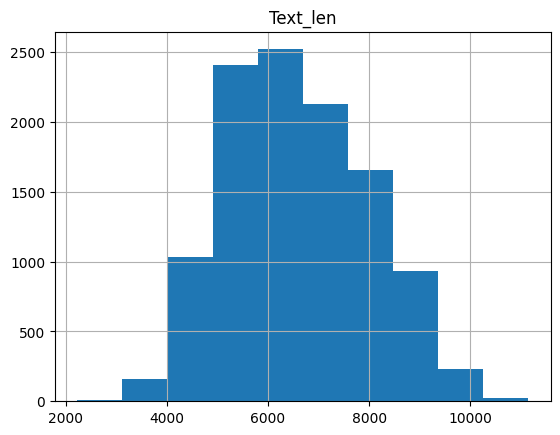

In [3]:
df_train['Text_len'] = df_train['Text'].apply(len)
df_train.hist(column=['Text_len'])

array([[<Axes: title={'center': 'metric'}>]], dtype=object)

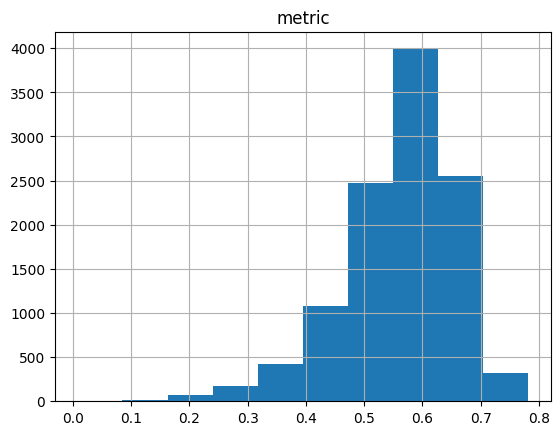

In [4]:
df_train.hist(['metric'])

Посмотрим пару примеров Text-summary с наибольшим и наименьшим значением оценки metrics

In [5]:
df_min = df_train.loc[df_train['metric'].idxmin()]
print(f"Text:\n-------\n{df_min['Text']}\n\nSummary:\n-------\n{df_min['summary']}\n\nMetric:\n-------\n{df_min['metric']}")

Text:
-------
TypeScript тип any против всех / Habr             

В жизни каждого разработчика на TypeScript наступает момент, когда ему хочется рвать все связи с типом any. А ведь по началу any казался таким милым! Сделай переменной аннотацию типа any и используй любое свойство и метод этой переменной так, как привык работать в JavaScript. Никаких тебе ошибок, все чинно и спокойно, по-старому.
Документация TypeScript оправдывает использование any только на время переноса кодовой базы из JavaScript в TypeScript, но считает постыдным его использование в полноценном проекте. Казалось бы, все хорошо, только в описании типов библиотечных функций самого TypeScript аннотации any встречаются. Очень полезный `JSON.parse`, один из таких примеров.
```
// из lib.es5.d.ts
interface JSON {
    parse(text: string, reviver?: (this: any, key: string, value: any) => any): any;
    stringify(value: any, replacer?: (this: any, key: string, value: any) => any, space?: string | number): string;
    stringi

In [6]:
df_max = df_train.loc[df_train['metric'].idxmax()]
print(f"Text:\n-------\n{df_max['Text']}\n\nSummary:\n-------\n{df_max['summary']}\n\nMetric:\n-------\n{df_max['metric']}")

Text:
-------
Искусственный интеллект поможет людям избавиться от фобий и страхов / Habr            

26-11-2016
Ну привет, арахнофоб. Как, ты меня уже не боишься? Страх имеет разную природу. Одно дело — испугаться падения с большой высоты, и другое — боязнь встретить дикое животное в лесу. А ведь есть еще различные фобии, которых сейчас просто не счесть. Ученые знают, что в момент, когда человек боится чего-нибудь, у него активизируется определенная область мозга. Боязнь падения с высоты активизирует иную область мозга, чем боязнь темноты и диких животных. В общем, каждый страх или фобия оставляют разные «отпечатки» активности нервной системы. Нейробиолог Хакван Лау (Hakwan Lau) и его коллеги из различных институтов, включая Колумбийский университет и Институт науки и технологий Нары (Япония), решили изучить, какие именно области мозга активизируются при появлении у одного и того же человека разных страхов. Возможно, считают ученые, это поможет избавить человека от фобий или фобии, ко

## Суммаризация с помощью базовой (фундаментальной) модели YandexGPT

Первый подход к решению задачи - использовать базовую модель YandexGPT и затравку для получения приемлимых обобщений текстов статей из Habr.

Сформируем вспомогательные переменные, которые необходимы при использовании модели.

o-auth: Документация про o-auth token лежит здесь - https://cloud.yandex.ru/docs/iam/concepts/authorization/oauth-token

iam-token: iam-token по o-auth токену получаем через командную стоку с помощью
>$ curl -d "{\"yandexPassportOauthToken\":\"<o-auth token>\"}" "https://iam.api.cloud.yandex.net/iam/v1/tokens"

!!! ВАЖНО: iam_token НУЖНО ОБНОВЛЯТЬ КАЖДЫЕ 12 ЧАСОВ !!!

folder_id: Также необходимо указать folder_id - каталог, в котором работает инфраструктура. Берется здесь - https://console.cloud.yandex.ru/folders

In [7]:
iam_token = "<iam-token>"
folder_id = "<folder-id>"

Переходим к тестовому файлу с примерами.

In [8]:
with open('data/test_articles_clear_100.json', 'r') as fin:
    test_examples_data = [json.loads(s) for s in fin.readlines()]

Для каждой статьи из тестового набора будем трижды обращаться к базовой модели суммаризации. Лучшая по оценке model_classify суммаризация summary_res записывается в строку json статьи по ключу summary_new. Также в строку json статьи записывается значение метрики лучшей суммаризации по ключу metric_new.

Подробнее об обращении к моделям - в файле _models.py_

In [9]:
llm_model = 0

n = 0
for r in test_examples_data:
    n += 1
    if (not ('metric_new' in r)) or (r['metric_new'] > 0.73):
        if not ('metric_new' in r):
            summary_res = ''
            metric_res = 0.
        else:
            summary_res = r['summary_new']
            metric_res = r['metric_new']

        for _ in range(0, 3):
            summary_temp = model_summarization(iam_token, folder_id, llm_model, r['Text'], max_t=3000, temp=0.75)
            metric_temp = model_classify(r['Text'], summary_temp)
            if metric_temp > metric_res:
                metric_res = metric_temp
                summary_res = summary_temp
            time.sleep(3)   # Задержка, чтобы модель не вылетала из-за частых обращений
        r['summary_new'] = summary_res
        r['metric_new'] = metric_res
        time.sleep(3)   # Задержка, чтобы модель не вылетала из-за частых обращений
        if n % 2 == 0:
            time.sleep(1)   # Задержка, чтобы модель не вылетала из-за частых обращений


Сохраним текущие результаты в файл.

In [10]:
with open('data/test_results_base.json', 'w') as base:
    base.write("\n".join([json.dumps(row, ensure_ascii=False) for row in test_examples_data]))

 Посмотрим текущую статистику метрики по суммаризации после экспериментов с фундаментальной моделью на графике и в числах.

In [11]:
with open('data/test_results_base.json', 'r') as base:
    test_examples_data = [json.loads(s) for s in base.readlines()]

(array([ 2.,  3.,  3.,  4., 11., 16., 35., 15.,  8.,  3.]),
 array([0.379639 , 0.4145755, 0.449512 , 0.4844485, 0.519385 , 0.5543215,
        0.589258 , 0.6241945, 0.659131 , 0.6940675, 0.729004 ]),
 <BarContainer object of 10 artists>)

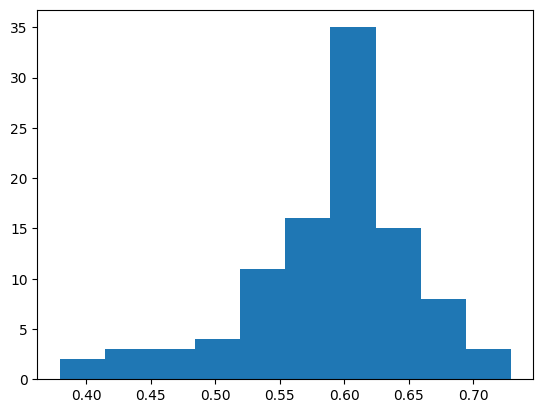

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([r['metric_new'] for r in test_examples_data])

In [13]:
sum_num = 0.
num = 0
lst_bad = []
for r in test_examples_data:
    if r['metric_new'] < 0.557:
        lst_bad.append(r['metric_new'])
    num += 1
    sum_num += r['metric_new']
print(f'В тестовом наборе {num} текстов.\nСреднее значение mean по всем примерам - {sum_num / num}.\nТекстов с низкой (меньше 0.557) оценкой metric - {len(lst_bad)}.\nСписок "плохих" метрик - {lst_bad}.' )

В тестовом наборе 100 текстов.
Среднее значение mean по всем примерам - 0.59060547.
Текстов с низкой (меньше 0.557) оценкой metric - 24.
Список "плохих" метрик - [0.525879, 0.498047, 0.421631, 0.464355, 0.542969, 0.538574, 0.544922, 0.433594, 0.534668, 0.519531, 0.552734, 0.532715, 0.484131, 0.467285, 0.522461, 0.408447, 0.429443, 0.379639, 0.49292, 0.545898, 0.505371, 0.551758, 0.499512, 0.554688].


Примеры Text-summary из тестового набора с наибольшим и наименьшим значением оценки metrics

In [14]:
line_min = test_examples_data[0].copy()
line_max = test_examples_data[0].copy()
for r in test_examples_data:
    if r['metric_new'] < line_min['metric_new']:
        line_min = r.copy()
    else:
        if r['metric_new'] > line_max['metric_new']:
            line_max = r.copy()

In [15]:
print(f"Статья с наименьшим значением metric:\n\nId:\n-------\n{line_min['id']}\n\nText:\n-------\n{line_min['Text']}\n\nSummary:\n-------\n{line_min['summary_new']}\n\nMetric:\n-------\n{line_min['metric_new']}")

Статья с наименьшим значением metric:

Id:
-------
95

Text:
-------
Обзор Sony Xperia XA Ultra. Большой смартфон по доступной цене / Habr              

27-09-2016
Из всей линейки Sony Xperia X модель XA Ultra – самая новая. Вернее она была представлена чуть позже, уже после официальной премьеры Xperia X, Xperia XA и Xperia X Performace. Как и все предыдущие модели со словом Ultra в названии, новый XA Ultra имеет крупный экран и усовершенствованную фронтальную камеру – с автофокусом и даже с отдельной светодиодной вспышкой. Внешний вид По своей концепции Xperia XA Ultra очень похож на прошлогодний C5 Ultra, а внешне напоминает увеличенный в размерах обычный Xperia XA. Впрочем, различаются модели не только габаритами. Одно из самых существенных отличий кроется во фронтальной камере. Об этом я расскажу ниже. Здесь огромный шестидюймовый экран закругляется по краям, стекло немного выпуклое, так называемое 2,5D. Кромка экрана практически незаметно сливается с боковыми гранями, смотрится о

In [16]:
print(f"Статья с наибольшим значением metric:\n\nId:\n-------\n{line_max['id']}\n\nText:\n-------\n{line_max['Text']}\nSummary:\n-------\n{line_max['summary_new']}\n\nMetric:\n-------\n{line_max['metric_new']}")

Статья с наибольшим значением metric:

Id:
-------
60

Text:
-------
ЦНИИмаш запатентовал лазерную систему опознавания «свой-чужой» для спутников / Habr                        

15-02-2018
3D-карта всех спутников и космического мусора на орбите Земли Система радиолокационного опознавания («Свой-чужой») — аппаратно-программный технический комплекс для автоматического отличения своих войск и вооружений от войск противника. Система традиционно используется в военном деле, начиная с племенной окраски первобытных племён, индейцев, использования татуировок. В современной армии каждое войско имеет форму установленного образца для различия своих и чужих солдат, а также систему паролей и отзывов. Но как осуществлять распознавание «свой-чужой» в космосе? Например, если радиолокационное опознавание по какой-то причине не работает. Или нужно определить принадлежность спутника по его обломкам? Интересное решение проблемы предлагают специалисты ЦНИИмаша — головного научного института госкорпорации «

## Fewshot

Необходимый (не менее 0.557) результат по среднему значению metric для обобщений из тестового набора на открытой модели получен (0.59060547). Теперь попробуем его увеличить.

Дообучим базовую модель YandexGPT с помощью примеров из train_data.
Ограничение по длине текста для дообучения базовой модели - 4К символов. Посмотрим, сколько текстов из train_data удовлетворяют ограничению.


In [17]:
print(f"Число примеров с текстами, длиной меньше 4000 = {len(df_train[df_train['Text_len'] <= 4000])}")

Число примеров с текстами, длиной меньше 4000 = 164


Для обучения нас интересуют только те тексты, для которых суммаризация имеет "хорошую" оценку. Поскольку базовое значение метрики в задании 0.557, посмотрим, сколько примеров суммаризаций имеет оценку >= 0.6.

In [18]:
print(f"Число примеров с текстами длины не более 4000 и у которых значение метрики суммаризации больше или равно 0.6 - {len(df_train[(df_train['Text_len'] <= 4000) & (df_train['metric'] >= 0.6)])}")

Число примеров с текстами длины не более 4000 и у которых значение метрики суммаризации больше или равно 0.6 - 24


Всего 24 примера. Немного. (

Однако ситуация еще хуже, поскольку в каждый пример few shot помимо текста статьи еще нужно включить затравку.
Посчитаем ее длину.

In [19]:
prompt = "\n\nОбобщение должно быть: связным по смыслу; понятным; без повторений; грамматически " \
              f"правильным; конкретным; законченным. Нужно давать четкие, краткие и прямые ответы. Обобщение должно " \
              f"занимать ровно один абзац. За качественное обобщение получишь чаевые до 200 долларов. Очень важно, " \
              f"чтобы обобщение было сделано правильно. На кону несколько жизней."
print(f'Длина затравки prompt == {len(prompt)}')

Длина затравки prompt == 348


Т.е. длина текста должна быть еще меньше - где-то 3650 символов.
Посчитаем, сколько таких примеров с хорошим значением метрики в train_data.

In [20]:
print(f"Число примеров с текстами длины не более 3650 и у которых значение метрики суммаризации больше или равно 0.6 - {len(df_train[(df_train['Text_len'] <= 3650) & (df_train['metric'] >= 0.6)])}")

Число примеров с текстами длины не более 3650 и у которых значение метрики суммаризации больше или равно 0.6 - 12


Посмотрим, хватит ли небольшого количества примеров для дообучения модели, чтобы в результате получить прирост по средней метрике качества.

In [21]:
df_good_short = df_train.loc[(df_train['Text_len'] <= 3650) & (df_train['metric'] >= 0.6)]
df_good_short.head()

,Text,metric,metric_input,summary,Text_len
353,"Тестируйте API, как профессионал. Часть 2: Как...",0.617188,"Текст статьи:\nТестируйте API, как профессиона...",cypress-plugin-api - это плагин для эффективно...,3500
5494,clipped() не оказывает влияния на проверку кас...,0.608398,Текст статьи:\nclipped() не оказывает влияния ...,В SwiftUI модификатор clipped() обрезает вью д...,3384
5558,"Тестируйте API, как профессионал. Часть 2: Как...",0.625488,"Текст статьи:\nТестируйте API, как профессиона...","Автор представляет плагин cypress-plugin-api, ...",3500
5688,Расширение и перемещение ансамбля ZooKeeper / ...,0.655762,Текст статьи:\nРасширение и перемещение ансамб...,Автор статьи рассказывает о проблеме перемещен...,3564
5760,"Реально честные светильники Армстронг, тестиро...",0.694336,Текст статьи:\nРеально честные светильники Арм...,Тестирование светодиодных светильников моделей...,3484


Распределение по качеству метрики выбранных примеров...

array([[<Axes: title={'center': 'metric'}>]], dtype=object)

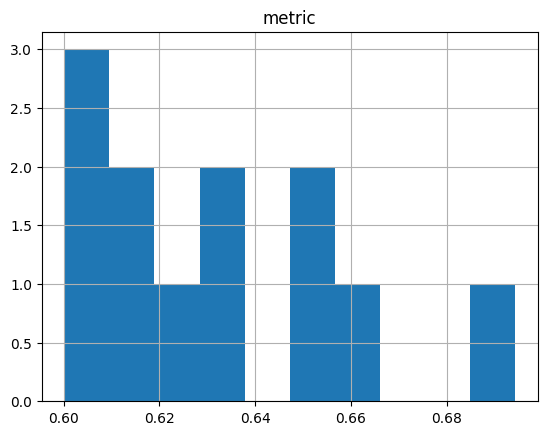

In [22]:
df_good_short.hist(['metric'])

...и по длине текстов

array([[<Axes: title={'center': 'Text_len'}>]], dtype=object)

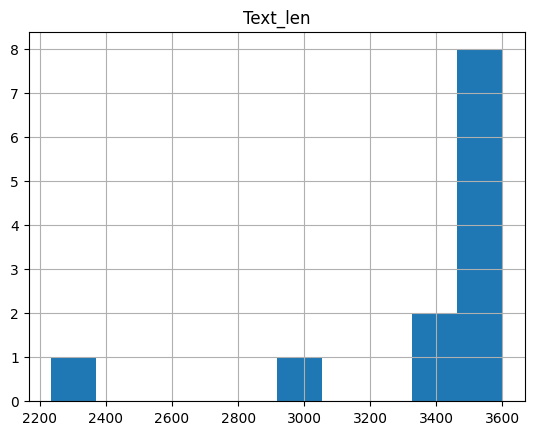

In [23]:
df_good_short.hist(column=['Text_len'])

Подготовим данные для дообучения фундаментальной модели YandexGPT, в формате (request, response), добавив в request затравку.

In [24]:
prompt = 'Обобщение должно быть: связным по смыслу; понятным; без повторений; грамматически правильным; конкретным; законченным. Нужно давать четкие, краткие и прямые ответы. Обобщение должно занимать ровно один абзац. За качественное обобщение получишь чаевые до 200 долларов. Очень важно, чтобы обобщение было сделано правильно. На кону несколько жизней."'

df_good_short.insert(len(df_good_short.columns), 'request', df_good_short.Text + '\n\n' + prompt)
df_good_short.insert(len(df_good_short.columns), 'response', df_good_short.summary)

In [25]:
data = [{'request': t.request, 'response': t.response} for t in df_good_short[['request', 'response']].itertuples()]
data[-1]

{'request': 'Молниеносный JSON в Ruby on Rails / Хабр                                                             \n\n28-09-2012\nВывод результата в JSON достаточно прост в Rails: render json: @statuses Это работает отлично, если нужно вывести небольшое количество записей. Но что случится, если нам потребуется вывести сразу 10\'000 записей? Производительность серьезно просядет, а самыми затратными по времени окажутся сериализация JSON и операции с базой данных. Включайте только необходимые атрибуты Первое очевидное решение — генерировать JSON только с необходимыми нам атрибутами, т.е.: render json: @statuses, methods: [:latitude, :longitude, :timestamp, :virtual_odometer] Отфильтрованный JSON даст нам более 20% прироста производительности: default 5.940000 0.080000 6.020000 ( 6.094221) attrs 4.820000 0.010000 4.830000 ( 4.932337) Делайте выборку только необходимых полей Второе решение — забирать из базы не все, а только необходимые нам поля. render json: @statuses.select([:latitude, :l

Сохраняем data в файл, в формате json для дообучения на few-shot фундаментальной модели.

In [26]:
with open('data/train_llm.json', 'w') as fp:
    json.dump(data, fp, ensure_ascii=False)

Продолжим генерацию обобщений текстов, на этот раз используя дообученную фундаментальную модель.
Аналогично тому, как делали прошлый раз, для статьи из тестового набора, у которой метрика меньше 0.6, будем трижды обращаться на этот раз к дообученной модели суммаризации.

In [27]:
llm_model = 1

n = 0
for r in test_examples_data:
    n += 1
    # print(f'Текст {n}: \n')
    if (not ('metric_new' in r)) or (r['metric_new'] > 0.73):
        if not ('metric_new' in r):
            summary_res = ''
            metric_res = 0.
        else:
            summary_res = r['summary_new']
            metric_res = r['metric_new']

        for _ in range(0, 3):
            summary_temp = model_summarization(iam_token, folder_id, llm_model, r['Text'], max_t=3000, temp=0.75)
            metric_temp = model_classify(r['Text'], summary_temp)
            if metric_temp > metric_res:
                metric_res = metric_temp
                summary_res = summary_temp
            time.sleep(3)   # Задержка, чтобы модель не вылетала из-за частых обращений
        r['summary_new'] = summary_res
        r['metric_new'] = metric_res
        time.sleep(3)   # Задержка, чтобы модель не вылетала из-за частых обращений
        if n % 2 == 0:
            time.sleep(1)   # Задержка, чтобы модель не вылетала из-за частых обращений


Сохраним результаты в файл.

In [28]:
with open('data/test_results_fin.json', 'w') as fin:
    fin.write("\n".join([json.dumps(row, ensure_ascii=False) for row in test_examples_data]))

Посмотрим статистику метрики по суммаризации после экспериментов с дообученной моделью на графике и в числах.

In [29]:
with open('test_results_fin.json', 'r') as fin:
    test_results_data = [json.loads(s) for s in fin.readlines()]

(array([ 3.,  5., 20., 32., 18., 11.,  3.,  5.,  1.,  2.]),
 array([0.552734, 0.570361, 0.587988, 0.605615, 0.623242, 0.640869,
        0.658496, 0.676123, 0.69375 , 0.711377, 0.729004]),
 <BarContainer object of 10 artists>)

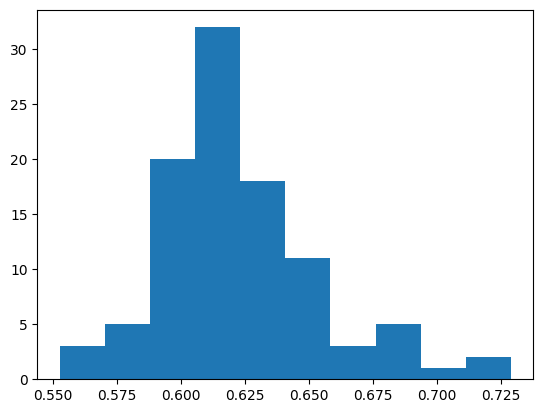

In [30]:
plt.hist([r['metric_new'] for r in test_results_data])

In [31]:
sum_num = 0.
num = 0
lst_bad = []
for r in test_results_data:
    if r['metric_new'] < 0.557:
        lst_bad.append(r['metric_new'])
    num += 1
    sum_num += r['metric_new']
print(f'В тестовом наборе {num} текстов.\nСреднее значение mean по всем примерам - {sum_num / num}.\nТекстов с низкой (меньше 0.557) оценкой metric - {len(lst_bad)}.\nСписок "плохих" метрик - {lst_bad}.' )

В тестовом наборе 100 текстов.
Среднее значение mean по всем примерам - 0.62374512.
Текстов с низкой (меньше 0.557) оценкой metric - 1.
Список "плохих" метрик - [0.552734].


Примеры Text-summary из тестового набора с наибольшим и наименьшим значением оценки metrics

In [32]:
line_min = test_results_data[0].copy()
line_max = test_results_data[0].copy()
for r in test_results_data:
    if r['metric_new'] < line_min['metric_new']:
        line_min = r.copy()
    else:
        if r['metric_new'] > line_max['metric_new']:
            line_max = r.copy()

In [33]:
print(f"Статья с наименьшим значением metric:\n\nId:\n-------\n{line_min['id']}\n\nText:\n-------\n{line_min['Text']}\n\nSummary:\n-------\n{line_min['summary_new']}\n\nMetric:\n-------\n{line_min['metric_new']}")

Статья с наименьшим значением metric:

Id:
-------
73

Text:
-------
Бюджетное видеонаблюдение для прижимистых «чайников» / Хабр                                                         

Скоро будет 7 лет с момента написания статьи "
Видеонаблюдение под Ubuntu для «чайников
» (ZoneMinder)". За эти годы она не раз корректировалась и обновлялась в связи с выходом новых версий, но кардинальная проблема, а именно — стоимость IP видеокамер, оставалась прежней. Её обходили оцифровывая аналоговые потоки и эмулируя IP камеры с помощью USB «вебок».

Ситуация изменилась с появлением китайских камер стандарта
ONVIF
2.0 (Open Network Video Interface Forum). Теперь любую камеру отвечающую стандарту вы можете настроить с помощью
ONVIF Device Manager
.

Более того, вы сразу можете увидеть адреса и параметры потоков вещания с камеры. Да, да. Теперь потоков, как минимум — 2, не считая звука. Один архивный — в максимальном качестве, другой — рабочий в меньшем разрешении.

_\* Все картинки кликабельны_



In [34]:
print(f"Статья с наибольшим значением metric:\n\nId:\n-------\n{line_max['id']}\n\nText:\n-------\n{line_max['Text']}\nSummary:\n-------\n{line_max['summary_new']}\n\nMetric:\n-------\n{line_max['metric_new']}")

Статья с наибольшим значением metric:

Id:
-------
60

Text:
-------
ЦНИИмаш запатентовал лазерную систему опознавания «свой-чужой» для спутников / Habr                        

15-02-2018
3D-карта всех спутников и космического мусора на орбите Земли Система радиолокационного опознавания («Свой-чужой») — аппаратно-программный технический комплекс для автоматического отличения своих войск и вооружений от войск противника. Система традиционно используется в военном деле, начиная с племенной окраски первобытных племён, индейцев, использования татуировок. В современной армии каждое войско имеет форму установленного образца для различия своих и чужих солдат, а также систему паролей и отзывов. Но как осуществлять распознавание «свой-чужой» в космосе? Например, если радиолокационное опознавание по какой-то причине не работает. Или нужно определить принадлежность спутника по его обломкам? Интересное решение проблемы предлагают специалисты ЦНИИмаша — головного научного института госкорпорации «

Текст с максимальной оценкой обобщения остался без изменения. Причина в том, что для текстов с оценкой обобщения больше 0.6 суммаризация дообученной моделью не производилась. При этом те статьи, которые получили бОльшую оценку metric на дообученой модели по сравнению с оценкой результатов работы фундаментальной модели, "перебить" планку в 0.729004 не смогли.

Текст с минимальной оценкой стал другим - 0.552734. Ранее оценка суммаризации текста была такой же, т.е. новая модель не смогла предложить лучшую суммаризацию.

А вот предыдущий аутсайдер в этот раз набрал 0.578613 (было 0.379639).
Ниже - сравнение обобщений этого текста для от разных моделей.

In [35]:
line_1 = {}
line_2 = {}
for r in test_examples_data:
    if r['id'] == 95:
        line_1 = r.copy()
for r in test_results_data:
    if r['id'] == 95:
        line_2 = r.copy()

print(f"Id:\n-------\n{line_1['id']}\n\nText:\n-------\n{line_1['Text']}\nSummary ({line_1['metric_new']}):\n-------\n{line_1['summary_new']}\n\nSummary ({line_2['metric_new']}):\n-------\n{line_2['summary_new']}")

Id:
-------
95

Text:
-------
Обзор Sony Xperia XA Ultra. Большой смартфон по доступной цене / Habr              

27-09-2016
Из всей линейки Sony Xperia X модель XA Ultra – самая новая. Вернее она была представлена чуть позже, уже после официальной премьеры Xperia X, Xperia XA и Xperia X Performace. Как и все предыдущие модели со словом Ultra в названии, новый XA Ultra имеет крупный экран и усовершенствованную фронтальную камеру – с автофокусом и даже с отдельной светодиодной вспышкой. Внешний вид По своей концепции Xperia XA Ultra очень похож на прошлогодний C5 Ultra, а внешне напоминает увеличенный в размерах обычный Xperia XA. Впрочем, различаются модели не только габаритами. Одно из самых существенных отличий кроется во фронтальной камере. Об этом я расскажу ниже. Здесь огромный шестидюймовый экран закругляется по краям, стекло немного выпуклое, так называемое 2,5D. Кромка экрана практически незаметно сливается с боковыми гранями, смотрится очень здорово. Боковых рамок практически

## Подготовка файла с результатами

In [36]:
result = [
    {
        'id': row['id'],
        'summary': row['summary_new']
    }
    for row in test_results_data
]

with open('data/test_output_jsonlines.json', 'w') as fin:
    fin.write("\n".join([
        json.dumps(row, ensure_ascii=False)
        for row in result
    ]))

## Результат

Дообученная модель даже на небольшом количестве (12) "хороших" примеров смогла повысить среднюю метрику качества на 100 текстах с полученного на фундаментальной модели значения 0.59060547 до 0.62374512.